In [2]:
%reset
#%qtconsole
%load_ext autoreload
%autoreload 2
%matplotlib inline 
import matplotlib.pyplot as plt
import functions as fun

import numpy as np
import matplotlib as mpl
from scipy import stats

from scipy.interpolate import interp1d,interp2d
from scipy.optimize import least_squares

import pandas as pd





Once deleted, variables cannot be recovered. Proceed (y/[n])? 
Nothing done.


In [3]:
sigma_t=0.01; # Input noise, determine how smooth the single neuron transfer function is 
tau_rp=0.002; # Refractory period

g_E=8.0; g_I=3.;beta=1.; # parameters characterizing the relative strength of synaptic connections
K=500; # average number of E connections per neuron (I connections are 1/4 of that)
sigma_Lambda_over_Lambda=1; # ratio between mean and standard deviation of the opsin expression

J=0.0006; # Synaptic efficacy in Volts
L=[0.,  20. ]; #  Laser intensity that fits the data
r_X=50*np.ones(1)
#[20,20,20]; # To speed up the code, I show results onlye for low anf high contrast and laser

Tmax_over_tau_E=100;

p=0.1; # probability of connection between cells. 
sigma_X_over_r_X=0.2; # Presynaptic population has mean rate r_X, Gaussianly distributed with std=0.2* r_X
Lambda=1*10**-3; # mean opsin expression in Volt

sigma_Lambda=sigma_Lambda_over_Lambda*Lambda

# In what follows, I compute W_{AB} starting from the parameters defined above
G_E,G_I=1.0,2.0 # Gain of Excitatory and inhibitory cells and I cells
w_EE=1;w_IE=w_EE/beta;
w_EI=g_E*w_EE;w_II=g_I*w_IE;
w_EX,w_IX=(G_I*fun.gamma*g_E-G_E)*w_EE,(G_I*fun.gamma*g_I-G_E)*w_IE; 
w_X=np.asarray([w_EX,w_IX]);
w=np.zeros((2,2));
w[0,:]=w_EE,-w_EI
w[1,:]=w_IE,-w_II



In [4]:
#'''
mu_tab_max=10.0;
mu_tab=np.linspace(-mu_tab_max,mu_tab_max,200000)
mu_tab=np.concatenate(([-10000],mu_tab))
mu_tab=np.concatenate((mu_tab,[10000]))

phi_tab_E,phi_tab_I=mu_tab*0,mu_tab*0;
for idx in range(len(phi_tab_E)):
    phi_tab_E[idx]=fun.comp_phi_tab(mu_tab[idx],fun.tau_E,tau_rp,sigma_t)
    phi_tab_I[idx]=fun.comp_phi_tab(mu_tab[idx],fun.tau_I,tau_rp,sigma_t)

phi_int_E=interp1d(mu_tab, phi_tab_E, kind='linear')  
phi_int_I=interp1d(mu_tab, phi_tab_I, kind='linear')
#'''

/Users/ale/Dropbox/research/Laser_on_E_cells/Draft_figures_simulations/Figure_4/simulations/simulations_vs_gs/functions.py:53: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  adelleh=integrate.quad(lambda u: f(u),minimo,massimo)
/Users/ale/Dropbox/research/Laser_on_E_cells/Draft_figures_simulations/Figure_4/simulations/simulations_vs_gs/functions.py:53: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  adelleh=integrate.quad(lambda u: f(u),minimo,massimo)


In [5]:
# Generate quenched disorder
M,mu_X_over_r_X_tau,Lambda_i,N_E,N_I=fun.Generate_quenched_disorder(sigma_X_over_r_X,J,K,w,w_X,p,Lambda,sigma_Lambda)


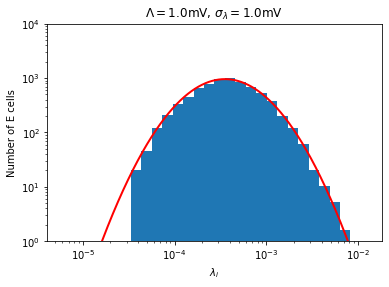

In [6]:
sigma_l=np.sqrt(np.log(1+sigma_Lambda_over_Lambda**2))
mu_l=np.log(Lambda)-sigma_l**2/2


count, bins, ignored = plt.hist(Lambda_i[0:N_E], 
                                10**np.linspace(np.log10(np.min(Lambda_i[0:N_E])*0.1),np.log10(1.1*np.max(Lambda_i[0:N_E])),33), 
                                density=True, align='mid')

plt.title(r'$\Lambda=$%.1fmV, $\sigma_\lambda=$%.1fmV'%(np.mean(Lambda_i[0:N_E])*10**3,np.std(Lambda_i[0:N_E])*10**3))
x = 10**np.linspace(min(np.log10(bins*0.5)), max(np.log10(bins*1.5)), 10000)
pdf = (np.exp(-(np.log(x) - mu_l)**2 / (2 * sigma_l**2))
       / (x * sigma_l * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda_i$')
plt.ylabel('Number of E cells')
plt.xlim([np.min(Lambda_i[0:N_E])*0.1,(1.1*np.max(Lambda_i[0:N_E]))])
plt.ylim([1,10**4])
plt.show()

In [7]:
print('Computing and saving network response')
T=np.arange(0,Tmax_over_tau_E*fun.tau_E,fun.tau_I/3);

mask_time=T>(10*fun.tau_E)
RATES=-1*np.ones((len(r_X),len(L),N_E+N_I))
DYNA=-1*np.ones((len(r_X),len(L),N_E+N_I,len(T)))
MUS=-1*np.ones((len(r_X),len(L),N_E+N_I))
Lambda_i_L=1./tau_rp*np.ones((len(r_X),len(L),N_E+N_I))
MFT_SOL_R=np.ones((len(r_X),len(L),10))
MFT_SOL_M=np.ones((len(r_X),len(L),10))
Phi=[phi_int_E,phi_int_I];
for idx_r_X in range(len(r_X)):
    for idx_L in range(len(L)):
        r_X_local,L_local=r_X[idx_r_X],L[idx_L];
        print((idx_r_X+1)/len(r_X),(idx_L+1)/len(L))
        DYNA[idx_r_X,idx_L,:,:], MUS[idx_r_X,idx_L,:],Lambda_i_L[idx_r_X,idx_L,:]=fun.High_dimensional_dynamics(T,L_local,r_X_local,M,mu_X_over_r_X_tau,Lambda_i,N_E,N_I,phi_int_E,phi_int_I);
        RATES[idx_r_X,idx_L,:]=np.mean(DYNA[idx_r_X,idx_L,:,mask_time],axis=0)
        print(np.mean(RATES[idx_r_X,idx_L,0:N_E]),
              np.mean(RATES[idx_r_X,idx_L,N_E::]),
              np.std(RATES[idx_r_X,idx_L,0:N_E]),
              np.std(RATES[idx_r_X,idx_L,N_E::]))
    Base_Sim=RATES[idx_r_X,0,:]
    Delta_Sim=RATES[idx_r_X,idx_L,:]-RATES[idx_r_X,0,:]

    moments_of_r_sim=np.zeros(5)
    moments_of_r_sim[0]=np.mean(Base_Sim)
    moments_of_r_sim[1]=np.mean(Delta_Sim)
    moments_of_r_sim[2]=np.std(Base_Sim)
    moments_of_r_sim[3]=np.std(Delta_Sim)
    moments_of_r_sim[4]=np.cov(Base_Sim,Delta_Sim)[0,1]
    print(moments_of_r_sim[:])


Computing and saving network response
1.0 0.5
70.50456174926013 115.49416122900948 116.6880767939309 101.53322778255101
1.0 1.0
72.92046199984877 118.27804311513938 119.58794494454885 102.8162968826648
[ 79.50248165   2.48949658 115.23252723  23.79553328  19.83634017]


<ipython-input-8-48da48abf256>:47: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist_Delta, bin_edges_Delta=np.histogram(Delta_Sim,bin_edges_Delta,normed=True)


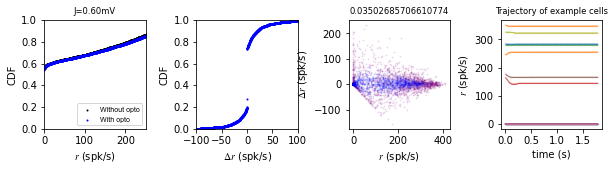

In [8]:
bin_edges=np.arange(0,1./tau_rp,.1)
spacings=np.diff(bin_edges)[0];
bin_means=0.5*(bin_edges[0:-1]+bin_edges[1::])
bin_edges_Delta=np.arange(-1./tau_rp,1./tau_rp,.1)
spacings_Delta=np.diff(bin_edges)[0];
bin_means_Delta=0.5*(bin_edges_Delta[0:-1]+bin_edges_Delta[1::])

fig, axs = plt.subplots(len(r_X),4, figsize=(2.5*4,2.0*len(r_X)), facecolor='w', edgecolor='k')#,sharey='row')#,sharex=True)
fig.subplots_adjust(hspace = .5, wspace=.5)
area=1.0;linethicknes=1.0;
axs = axs.ravel()
font = {'family' : 'normal','weight' : 'normal','size'   : 7, 'family':'serif','serif':['Arial']}
mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] =linethicknes
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['pdf.fonttype'] = 42

for idx_r_X in range(len(r_X)):
    maks_cells=(RATES[idx_r_X,1,:]+RATES[idx_r_X,0,:])>=0

    color=['k','b',];
    idx_cell=0;
    sol_M=MFT_SOL_M[idx_r_X,idx_L,:]
    mu,S2_mu=sol_M[idx_cell],sol_M[idx_cell+2]
    delta_mu,S2_delta_mu,Cov_mu_delta_mu=sol_M[idx_cell+4],sol_M[idx_cell+6],sol_M[idx_cell+8]
    Frac=[1,0]
    label=['Without opto','With opto']
    for idx_L in range(len(L)):
        #hist, bin_edges=np.histogram(RATES[idx_r_X,idx_L,0:N_E],bin_edges)#,normed=True)
        hist, bin_edges=np.histogram(RATES[idx_r_X,idx_L,maks_cells],bin_edges)#,normed=True)
        bin_mean=0.5*(bin_edges[0:-1]+bin_edges[1::])
        spacings=np.diff(bin_edges)[0];
        hist=hist/np.sum(hist*spacings)
        axs[idx_r_X*4+0].scatter(bin_mean,np.cumsum(spacings*hist),c=color[idx_L],s=area,label=label[idx_L])
    '''    
        P_of_nu=fun.P_of_r_A(bin_edges,Phi[idx_cell],
                       mu,S2_mu,delta_mu,
                       S2_delta_mu,Cov_mu_delta_mu,
                       L[idx_L],Lambda,sigma_Lambda,Frac[idx_cell]);
        axs[idx_r_X*4+0].plot(bin_mean,np.cumsum(P_of_nu[:]*spacings),c='purple')    
    '''
    #Delta_Sim=RATES[idx_r_X,1,0:N_E]-RATES[idx_r_X,0,0:N_E]

    Delta_Sim=RATES[idx_r_X,1,maks_cells]-RATES[idx_r_X,0,maks_cells]
    hist_Delta, bin_edges_Delta=np.histogram(Delta_Sim,bin_edges_Delta,normed=True)
    CDF_Resp_Delta=np.cumsum(hist_Delta*spacings_Delta)
    axs[idx_r_X*4+1].scatter(bin_means_Delta,CDF_Resp_Delta,c='b',s=area);

    #axs[idx_r_X*4+2].scatter(RATES[idx_r_X,0,maks_cells],RATES[idx_r_X,1,maks_cells]-RATES[idx_r_X,0,maks_cells],c='b',s=1,alpha=0.3);
    idx_cells=np.where(Lambda_i>0)
    axs[idx_r_X*4+2].scatter(RATES[idx_r_X,0,idx_cells],RATES[idx_r_X,1,idx_cells]-RATES[idx_r_X,0,idx_cells],c='purple',s=1,alpha=0.1);
    idx_cells=np.where((Lambda_i==0)&(np.arange(len(Lambda_i))<N_E))
    axs[idx_r_X*4+2].scatter(RATES[idx_r_X,0,idx_cells],RATES[idx_r_X,1,idx_cells]-RATES[idx_r_X,0,idx_cells],c='r',s=1,alpha=0.1);
    idx_cells=np.where((Lambda_i==0)&(np.arange(len(Lambda_i))>N_E))
    axs[idx_r_X*4+2].scatter(RATES[idx_r_X,0,idx_cells],RATES[idx_r_X,1,idx_cells]-RATES[idx_r_X,0,idx_cells],c='b',s=1,alpha=0.1);

    cov=np.cov(RATES[idx_r_X,0,:],RATES[idx_r_X,1,:]-RATES[idx_r_X,0,:])
    axs[idx_r_X*4+2].set_title(cov[0,1]/cov[1,1])
    '''
    P_of_nu=fun.P_of_delta_r_A(bin_edges_Delta,Phi[idx_cell],
                       mu,S2_mu,delta_mu,
                       S2_delta_mu,Cov_mu_delta_mu,
                       L[1],Lambda,sigma_Lambda,Frac[idx_cell]);

    axs[1].plot(bin_means_Delta,np.cumsum(P_of_nu*spacings_Delta),c='purple')
    '''


    for idx_cell in range(17):
        axs[idx_r_X*4+3].plot(T[mask_time]-T[mask_time][0],DYNA[idx_r_X,1,idx_cell,mask_time],marker='o',markersize=0.1,alpha=0.5)

    axs[idx_r_X*4+0].axis([0,250,.0,1.])
    axs[idx_r_X*4+0].legend(loc='lower right')
    axs[idx_r_X*4+1].axis([-100,100,0,1.])
    axs[idx_r_X*4+0].set_title('J=%.2fmV'%(J*10**3))
    axs[idx_r_X*4+0].set_ylabel('CDF')
    axs[idx_r_X*4+1].set_ylabel('CDF')
    axs[idx_r_X*4+0].set_xlabel('$r$ (spk/s)')
    axs[idx_r_X*4+1].set_xlabel('$\Delta r$ (spk/s)')
    axs[idx_r_X*4+2].set_ylabel('$\Delta r$ (spk/s)')
    axs[idx_r_X*4+2].set_xlabel('$r$ (spk/s)')
    axs[idx_r_X*4+3].set_ylabel('$r$ (spk/s)')
    axs[idx_r_X*4+3].set_xlabel('time (s)')
    axs[idx_r_X*4+3].set_title('Trajectory of example cells')



In [76]:
idx_r_X,idx_L=0,-1
Base_Sim=RATES[idx_r_X,0,:]
Delta_Sim=RATES[idx_r_X,idx_L,:]-RATES[idx_r_X,0,:]

moments_of_r_sim=np.zeros(5)
moments_of_r_sim[0]=np.mean(Base_Sim)
moments_of_r_sim[1]=np.mean(Delta_Sim)
moments_of_r_sim[2]=np.std(Base_Sim)
moments_of_r_sim[3]=np.std(Delta_Sim)
moments_of_r_sim[4]=np.cov(Base_Sim,Delta_Sim)[0,1]
print(moments_of_r_sim[:])


pippo_m=np.mean(DYNA[idx_r_X,idx_L,:,0:np.int32(len(T)/2)],axis=1)-np.mean(DYNA[idx_r_X,idx_L,:,np.int32(len(T)/2)::],axis=1)
pippo_p=np.mean(DYNA[idx_r_X,idx_L,:,0:np.int32(len(T)/2)],axis=1)+np.mean(DYNA[idx_r_X,idx_L,:,np.int32(len(T)/2)::],axis=1)

pippo_n=pippo_m/pippo_p


print('Saving results')
# simulations param+mean results+ meaurements of rate convergence

sim_param=np.asarray([sigma_t,tau_rp,g_E,g_I,beta,K,p,sigma_X_over_r_X,1,
      Lambda,sigma_Lambda_over_Lambda,J,r_X[idx_r_X],L[idx_L],Tmax_over_tau_E])
sim_results=moments_of_r_sim
sim_convergence=np.asarray([np.std(pippo_m),np.max(np.abs(pippo_m)),
                           np.std(pippo_n),np.max(np.abs(pippo_n))])


pippo_E=np.cov(Base_Sim[0:N_E],Delta_Sim[0:N_E])
pippo_I=np.cov(Base_Sim[N_E::],Delta_Sim[N_E::])

idx_r_X=0;idx_L=0;
idx_T_all=np.where((T>np.max(T)/2))[0]
auto=np.zeros(len(idx_T_all))
count=0;
for idx_T in idx_T_all:
    pippo=np.corrcoef(DYNA[idx_r_X,idx_L,:,idx_T],DYNA[idx_r_X,idx_L,:,idx_T_all[0]])
    auto[count]=pippo[0,1]
    count=count+1
max_decay=(np.max(T[idx_T_all])-np.min(T[idx_T_all]))
tau_decay=max_decay
idx_decay=np.argmin(np.abs(auto-0.5))
if np.min(auto)<0.95:
    tau_decay=T[0:len(auto)][idx_decay]
print(tau_decay,max_decay)    
    
    
additional_measurements=[pippo_E[0,1]/pippo_E[1,1],pippo_I[0,1]/pippo_I[1,1],tau_decay,max_decay]
results=np.zeros((1,len(sim_param)
                  +len(sim_results)
                 +len(sim_convergence)
                 +len(additional_measurements)))

results[0,0:len(sim_param)]=sim_param[:]
results[0,len(sim_param):(len(sim_param)+len(sim_results))]=sim_results
results[0,(len(sim_param)+len(sim_results)):(len(sim_param)+len(sim_results)+len(sim_convergence))]=sim_convergence
results[0,(len(sim_param)+len(sim_results)+len(sim_convergence))::]=additional_measurements



[  34.12083381    2.47870572   68.29102564   33.52862942 -301.07017627]
Saving results
0.26 0.9966666666666668


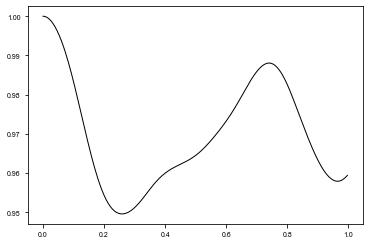

In [77]:
color=['k','b']
#idx_T_all=np.where((T>30*fun.tau_I)&(T<40*fun.tau_I))[0]
plt.plot(T[0:len(auto)],auto,c=color[idx_L])


In [45]:
rel_decay

1